# Creating a Bipartite Graph Database of Lawmakers and Bills

__Project 2__

In this Project, Joy and Sonya will:

* Identify a large 2+ node type network dataset
* Establish edges between and not within two or more distinct groups.
* Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
* Make inferences about each of the distinct groups

Steps include:

* working with a ProPublica API
* creating nodes for Senators and active Senate Bills
* creating edges for "sponsorship" -- a senator sponsors a bill

## Import Needed Packages

In [1]:
import requests
import json
import networkx as net
import networkx.algorithms.bipartite as bipartite
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Create Function to Run API

In [2]:
def propublica(url):
    r = requests.get(url, headers={'X-API-Key': '###REDACTED###'})  
    data = json.loads(r.text)
    return (data)

## Get List of Senators via API

In [3]:
senators = propublica("https://api.propublica.org/congress/v1/115/senate/members.json")['results'][0]['members']
df_senators = pd.DataFrame(senators)
df_senators.head()

,api_uri,contact_form,crp_id,cspan_id,date_of_birth,dw_nominate,facebook_account,fax,fec_candidate_id,first_name,...,state,state_rank,title,total_present,total_votes,twitter_account,url,votes_with_party_pct,votesmart_id,youtube_account
0,https://api.propublica.org/congress/v1/members...,http://www.alexander.senate.gov/public/index.c...,N00009888,5,1940-07-03,0.323,senatorlamaralexander,202-228-3398,S2TN00058,Lamar,...,TN,senior,"Senator, 2nd Class",0,216,SenAlexander,https://www.alexander.senate.gov/public/,98.56,15691,lamaralexander
1,https://api.propublica.org/congress/v1/members...,https://www.baldwin.senate.gov/feedback,N00004367,57884,1962-02-11,-0.546,TammyBaldwin,202-225-6942,S2WI00219,Tammy,...,WI,junior,"Senator, 1st Class",1,216,SenatorBaldwin,https://www.baldwin.senate.gov/,95.37,3470,witammybaldwin
2,https://api.propublica.org/congress/v1/members...,https://www.barrasso.senate.gov/public/index.c...,N00006236,1024777,1952-07-21,0.528,johnbarrasso,202-224-1724,S6WY00068,John,...,WY,junior,"Senator, 1st Class",0,216,SenJohnBarrasso,https://www.barrasso.senate.gov/,99.07,52662,barrassowyo
3,https://api.propublica.org/congress/v1/members...,https://www.bennet.senate.gov/?p=contact,N00030608,1031622,1964-11-28,-0.208,senbennetco,202-228-5097,S0CO00211,Michael,...,CO,senior,"Senator, 3rd Class",1,216,SenBennetCo,https://www.bennet.senate.gov/,90.70,110942,SenatorBennet
4,https://api.propublica.org/congress/v1/members...,https://www.blumenthal.senate.gov/contact/,N00031685,21799,1946-02-13,-0.418,SenBlumenthal,202-224-9673,S0CT00177,Richard,...,CT,senior,"Senator, 3rd Class",1,216,SenBlumenthal,https://www.blumenthal.senate.gov/,90.23,1568,SenatorBlumenthal


### Show the Column Names

In [4]:
df_senators.columns

Index([u'api_uri', u'contact_form', u'crp_id', u'cspan_id', u'date_of_birth',
       u'dw_nominate', u'facebook_account', u'fax', u'fec_candidate_id',
       u'first_name', u'google_entity_id', u'govtrack_id', u'icpsr_id', u'id',
       u'ideal_point', u'in_office', u'last_name', u'leadership_role',
       u'lis_id', u'middle_name', u'missed_votes', u'missed_votes_pct',
       u'next_election', u'ocd_id', u'office', u'party', u'phone', u'rss_url',
       u'senate_class', u'seniority', u'short_title', u'state', u'state_rank',
       u'title', u'total_present', u'total_votes', u'twitter_account', u'url',
       u'votes_with_party_pct', u'votesmart_id', u'youtube_account'],
      dtype='object')

### Show IDs of Senators

In [5]:
df_senators['id'].head()

0    A000360
1    B001230
2    B001261
3    B001267
4    B001277
Name: id, dtype: object

## Get Recent Active Bills

The API will only send 20 at a go, so we have to paginate!

In [6]:
url = "https://api.propublica.org/congress/v1/115/senate/bills/active.json?offset="
offset = 0
apiResults = propublica(url + str(offset))
activeBills = apiResults['results'][0]['bills']
while True:
    offset = offset + 20
    apiResults = propublica(url + str(offset))
    moreBills = apiResults['results'][0]['bills']
    if len(moreBills) == 0:
        break
    activeBills += moreBills
    time.sleep(.25)  # Be friendly and don't overwhelm the server with a bunch of fast queries

### Get number of active bills

In [7]:
len(activeBills)

388

### Show the kind of data are we given about active bills

In [8]:
pd.DataFrame(activeBills).columns

Index([u'active', u'bill_id', u'bill_slug', u'bill_type', u'bill_uri',
       u'committee_codes', u'committees', u'congressdotgov_url', u'cosponsors',
       u'cosponsors_by_party', u'enacted', u'govtrack_url', u'gpo_pdf_uri',
       u'house_passage', u'introduced_date', u'latest_major_action',
       u'latest_major_action_date', u'number', u'primary_subject',
       u'senate_passage', u'short_title', u'sponsor_id', u'sponsor_name',
       u'sponsor_party', u'sponsor_state', u'sponsor_title', u'sponsor_uri',
       u'subcommittee_codes', u'summary', u'summary_short', u'title',
       u'vetoed'],
      dtype='object')

### Take a quick peek at the data

In [9]:
pd.DataFrame(activeBills).head()

,active,bill_id,bill_slug,bill_type,bill_uri,committee_codes,committees,congressdotgov_url,cosponsors,cosponsors_by_party,...,sponsor_name,sponsor_party,sponsor_state,sponsor_title,sponsor_uri,subcommittee_codes,summary,summary_short,title,vetoed
0,True,sconres25-115,sconres25,sconres,https://api.propublica.org/congress/v1/115/bil...,[SSBU],Senate Budget Committee,https://www.congress.gov/bill/115th-congress/s...,0,{},...,Michael B. Enzi,R,WY,Sen.,https://api.propublica.org/congress/v1/members...,[],,,An original concurrent resolution setting fort...,None
1,True,s1595-115,s1595,s,https://api.propublica.org/congress/v1/115/bil...,"[HSFA, SSBK]",House Financial Services Committee,https://www.congress.gov/bill/115th-congress/s...,36,"{u'R': 21, u'D': 15}",...,Marco Rubio,R,FL,Sen.,https://api.propublica.org/congress/v1/members...,[],,,Hizballah International Financing Prevention A...,None
2,True,s585-115,s585,s,https://api.propublica.org/congress/v1/115/bil...,"[HSGO, HSVR, SSGA]",House Veterans&#39; Affairs Committee,https://www.congress.gov/bill/115th-congress/s...,1,{u'R': 1},...,Ron Johnson,R,WI,Sen.,https://api.propublica.org/congress/v1/members...,"[HSVR08, HSVR10]",(This measure has not been amended since it w...,(This measure has not been amended since it w...,Dr. Chris Kirkpatrick Whistleblower Protection...,None
3,True,s920-115,s920,s,https://api.propublica.org/congress/v1/115/bil...,[SSHR],"Senate Health, Education, Labor, and Pensions ...",https://www.congress.gov/bill/115th-congress/s...,2,"{u'R': 1, u'D': 1}",...,Jeanne Shaheen,D,NH,Sen.,https://api.propublica.org/congress/v1/members...,[],National Clinical Care Commission Act (Sec. 2)...,National Clinical Care Commission Act (Sec. 2)...,National Clinical Care Commission Act,None
4,True,s190-115,s190,s,https://api.propublica.org/congress/v1/115/bil...,[SSEG],Senate Energy and Natural Resources Committee,https://www.congress.gov/bill/115th-congress/s...,1,{u'D': 1},...,Cory Gardner,R,CO,Sen.,https://api.propublica.org/congress/v1/members...,[],(This measure has not been amended since it wa...,(This measure has not been amended since it wa...,Power And Security Systems (PASS) Act,None


## Create a Graph of Senators and Bills Using NetworkX

First, we'll simplify our Senators and Bills data!

### Simplify Senators

In [10]:
simplifiedSenators = [dict.fromkeys(["id", "first_name", "middle_name", "last_name", "party", "seniority", "party_rank"])]

for senator in senators:
    simplifiedSenator = {key: senator[key] for key in senator if key in \
                      ['id','first_name','middle_name','last_name','party','seniority','state_rank']}
    simplifiedSenators.append(simplifiedSenator)

### Take a look at the simplified senators

In [11]:
pd.DataFrame(simplifiedSenators).head()

,first_name,id,last_name,middle_name,party,party_rank,seniority,state_rank
0,None,None,None,None,None,NaN,None,NaN
1,Lamar,A000360,Alexander,None,R,NaN,15,senior
2,Tammy,B001230,Baldwin,None,D,NaN,5,junior
3,John,B001261,Barrasso,None,R,NaN,11,junior
4,Michael,B001267,Bennet,None,D,NaN,9,senior


### Remove "None" row 

That "None" row is going to cause a problem!  I'll remove it.

In [12]:
simplifiedSenators.pop(0)
pd.DataFrame(simplifiedSenators).head()

,first_name,id,last_name,middle_name,party,seniority,state_rank
0,Lamar,A000360,Alexander,None,R,15,senior
1,Tammy,B001230,Baldwin,None,D,5,junior
2,John,B001261,Barrasso,None,R,11,junior
3,Michael,B001267,Bennet,None,D,9,senior
4,Richard,B001277,Blumenthal,None,D,7,senior


### Simplify Bills

In [13]:
simplifiedBills = [dict.fromkeys(['bill_slug','title','sponsor_id','primary_subject','sponsor_party'])]
for activeBill in activeBills:
    simplifiedBill = {key: activeBill[key] for key in activeBill if key in \
                      ['bill_slug','title', 'sponsor_id','primary_subject','sponsor_party']}
    simplifiedBills.append(simplifiedBill)

### Take a look at the simplified bills:

In [14]:
pd.DataFrame(simplifiedBills).head()

,bill_slug,primary_subject,sponsor_id,sponsor_party,title
0,None,None,None,None,None
1,sconres25,,E000285,R,An original concurrent resolution setting fort...
2,s1595,International Affairs,R000595,R,Hizballah International Financing Prevention A...
3,s585,Government Operations and Politics,J000293,R,Dr. Chris Kirkpatrick Whistleblower Protection...
4,s920,Health,S001181,D,National Clinical Care Commission Act


### Remove "None" row 

That "None" row is going to cause a problem!  I'll remove it.

In [15]:
simplifiedBills.pop(0)
pd.DataFrame(simplifiedBills).head()

,bill_slug,primary_subject,sponsor_id,sponsor_party,title
0,sconres25,,E000285,R,An original concurrent resolution setting fort...
1,s1595,International Affairs,R000595,R,Hizballah International Financing Prevention A...
2,s585,Government Operations and Politics,J000293,R,Dr. Chris Kirkpatrick Whistleblower Protection...
3,s920,Health,S001181,D,National Clinical Care Commission Act
4,s190,Energy,G000562,R,Power And Security Systems (PASS) Act


Now we have simplified data that's nice and clean.  Let's create a graph that links senators to the bills they sponsored.

In [16]:
g = net.Graph()
for senator in simplifiedSenators:
    # I want to distinguish between senators and bills, so I'll add this "bipartite" attribute.
    g.add_node(senator['id'], attr_dict=senator, bipartite=0)  

In [17]:
for bill in simplifiedBills:
    # I want to distinguish between senators and bills, so I'll add this "bipartite" attribute.
    g.add_node(bill['bill_slug'], attr_dict=bill, bipartite = 1)
    g.add_edge(bill['sponsor_id'],bill['bill_slug'])

## Get Bill Cosponsors

Bills also have cosponsors, in some cases, so we should have those links in place as well!

First, find the bills that had some cosponsors but that weren't runaway, whole-party or whole-senate cosponsorships. We're looking for the sweet spot between, say, 1 and 20 co-sponsors, where the group of sponsors is small enough that working together on the bill would be an actual social connection, not just a rubber-stamp.

### Get Cosponsored Bills

In [18]:
df_activeBills = pd.DataFrame(activeBills)
cosponsoredBills = df_activeBills[(df_activeBills['cosponsors'] > 0) & (df_activeBills['cosponsors'] <= 20)]
cosponsoredBills = cosponsoredBills[['bill_slug','sponsor_id', 'cosponsors']]
cosponsoredBills.head()

,bill_slug,sponsor_id,cosponsors
2,s585,J000293,1
3,s920,S001181,2
4,s190,G000562,1
5,s1617,C001056,6
6,s1103,J000293,1


Then, lookup the info on each cosponsored bill, collect all the cosponsors of that bill and link cosponsors to bills with edges.

### Create Edges for Cosponsorship

For each cosponsored bill, link each bill and its cosponsoring senators.

In [19]:
for index, row in cosponsoredBills.iterrows():
    cosponsorInfo = pd.DataFrame(propublica("https://api.propublica.org/congress/v1/115/bills/" + \
                                            row['bill_slug'] + "/cosponsors.json")\
                                            ['results'][0]['cosponsors'])

    for cosponsor in cosponsorInfo['cosponsor_id']: # for each cosponsor
        g.add_edge(cosponsor,row['bill_slug'], bipartite=1) # link cosponsoring Senator to the bill
        

### Graph attractively

First we want to make sure that senators and bills are separate node lists, so we can plot them in different colors.  We'll make the node size dependent on the degree of each node!

In [20]:
senators, bills = bipartite.sets(g)

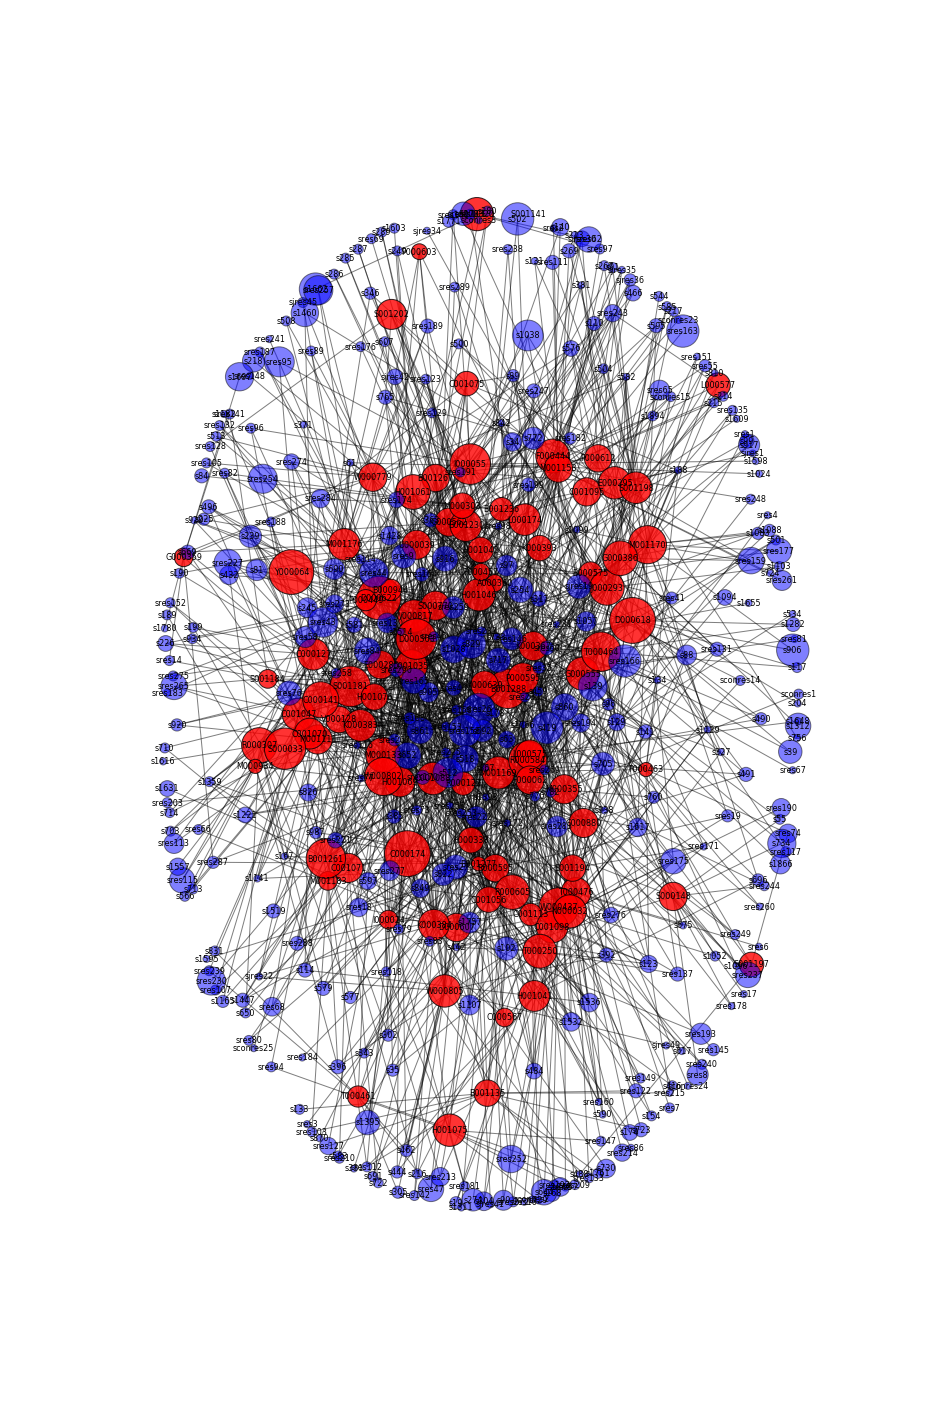

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

pos=net.spring_layout(g, k=0.08) # positions for all nodes, nicely spread apart.

# calculate degree centrality
senatorDegree = net.degree(g, senators) 
billDegree = net.degree(g, bills)

plt.figure(1,figsize=(16,25)) 

# nodes
net.draw_networkx_nodes(g,pos,
                       nodelist=senators,
                       node_color='r',
                       node_size=[v * 50 for v in senatorDegree.values()],
                   alpha=0.8)
net.draw_networkx_nodes(g,pos,
                       nodelist=bills,
                       node_color='b',
                       node_size=[v * 50 for v in billDegree.values()],
                   alpha=0.5)

# edges
net.draw_networkx_edges(g,pos,width=1.0,alpha=0.5)
net.draw_networkx_labels(g,pos,font_size=8,font_family='sans-serif')
plt.axis('off')
plt.show() # display

## Check for Isolates

All bills have a senator who sponsor them, but it's possible we have senators who haven't sponsored anything.  Is that the case? 

In [22]:
net.isolates(g)

[u'S001141']

In [23]:
print(net.get_node_attributes(g,'first_name').get('S001141'))
print(net.get_node_attributes(g,'last_name').get('S001141'))

Jeff
Sessions


## Closer examination of Senators

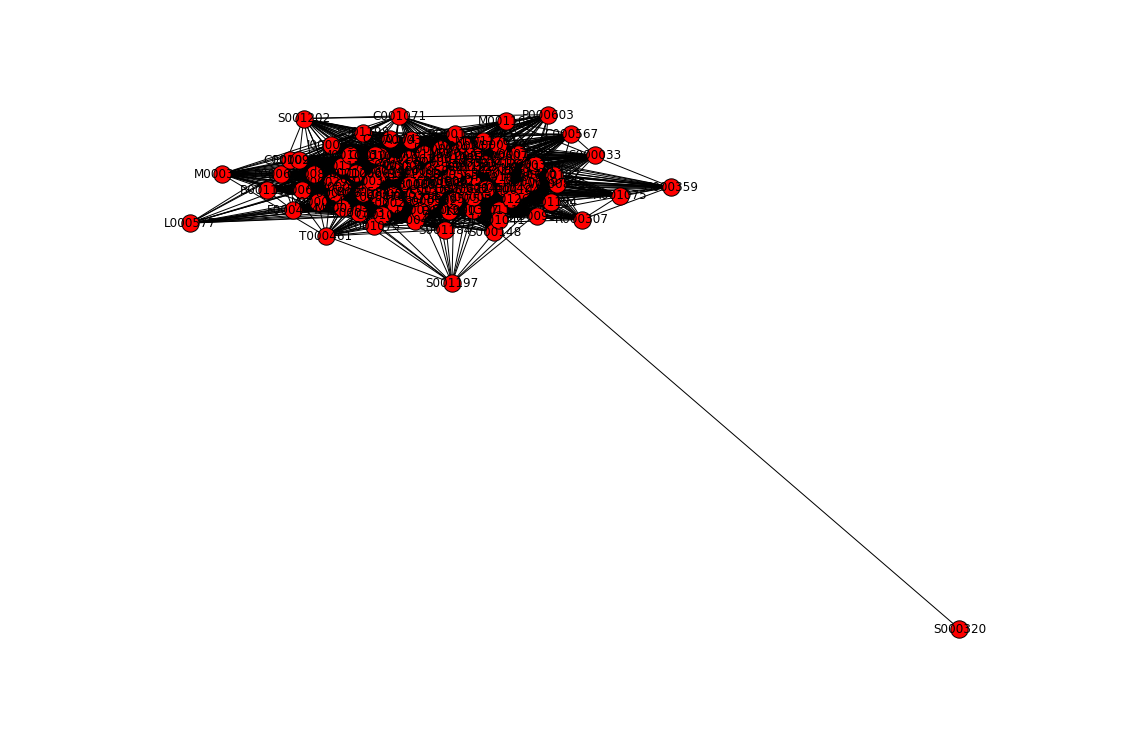

In [24]:
s = bipartite.weighted_projected_graph(g, senators)
plt.figure(2,figsize=(15,10)) 
net.draw_spring(s, with_labels = True)

Ugh, we have quite a knotty group of senators in our "big island" of interrelations.  Let's see if we can reduce our network by using thresholding, aka the "island method" in our graph.  

### Island Method

We take the following code directly from our textbook.  "island_method" will use "trim_edges" to reduce the graph to various levels of interconnectivity (effectively removing low-connectivity edges) and will return the number of clusters resulting from this thresholding.

In [25]:
def trim_edges(g, weight=1):
        g2=net.Graph()
        for f, to, edata in g.edges(data=True):
                if edata['weight'] > weight:
                        g2.add_edge(f,to,edata)
        return g2
def island_method(g, iterations=5):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]

    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/iterations)

    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [26]:
senator_islands=island_method(s)

Let's take a peek at the results of the island technique:

In [27]:
senator_islands

[[1, <networkx.classes.graph.Graph at 0x11c967550>],
 [4, <networkx.classes.graph.Graph at 0x11c967650>],
 [7, <networkx.classes.graph.Graph at 0x11c967210>],
 [10, <networkx.classes.graph.Graph at 0x11c967690>],
 [13, <networkx.classes.graph.Graph at 0x11c9676d0>],
 [16, <networkx.classes.graph.Graph at 0x11c613e90>]]

We have six threshold levels to consider.  Let's check them out, from highest to lowest.  We'll look at the second element (the graph) of the sixth island result (remember that python is zero-indexed).  Then we'll look at the graph for the fifth island result, the fourth, and so on. 

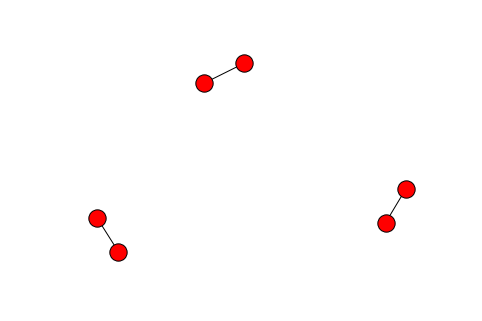

In [28]:
net.draw(senator_islands[5][1])  

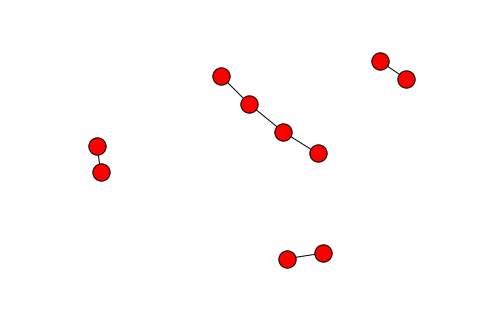

In [29]:
net.draw(senator_islands[4][1])  

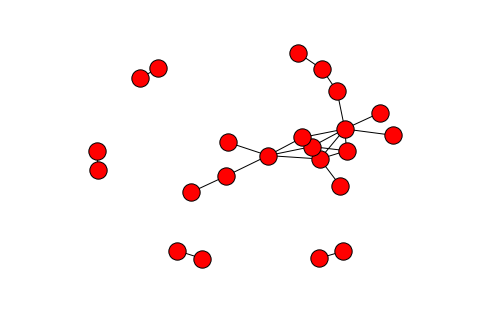

In [30]:
net.draw(senator_islands[3][1])  

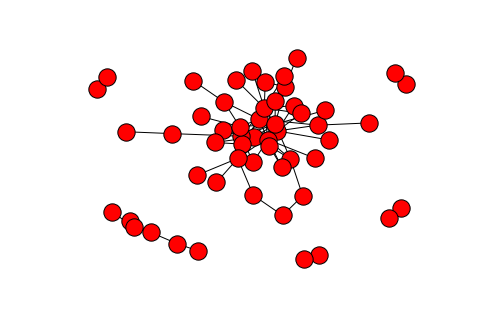

In [31]:
net.draw(senator_islands[2][1])  

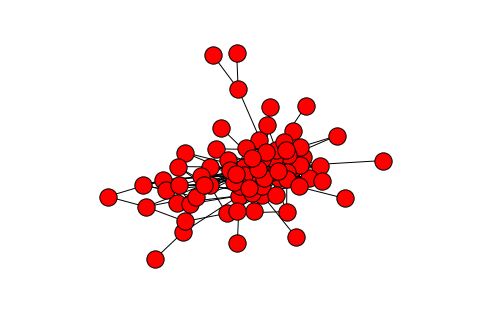

In [32]:
net.draw(senator_islands[1][1])  

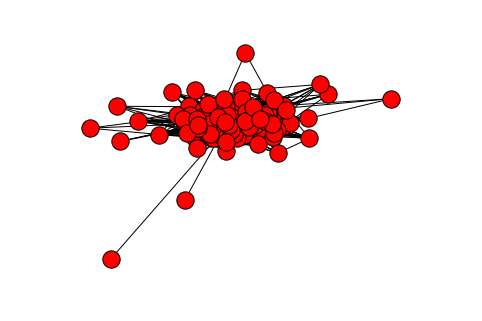

In [33]:
net.draw(senator_islands[0][1])  

We like the results for `net.draw(senator_islands[4][1])` the best -- not too complex or populous, but not too sparse, either.  Let's check out these islands, which should show us highly connected (and therefore we could surmise highly influential) senators.

In [34]:
special_senators = senator_islands[4][1]
graphs = list(net.connected_component_subgraphs(special_senators))
print len(graphs)

4


In [35]:
def senate_island_display(graph):
    senator_names = []
    node_ids = []
    dems = 0
    reps = 0
    for n in graph:
        name = s.node[n]['first_name'] + ' ' + s.node[n]['last_name'] \
            + ' (' + s.node[n]['party'] + ')'
        if s.node[n]['party'] == 'R':
            reps +=1
        if s.node[n]['party'] == 'D':
            dems +=1    
        node_ids.append(n)
        senator_names.append(name)
    senator_dict = dict(zip(node_ids, senator_names))

    pos=net.spring_layout(graph)
    plt.figure(1,figsize=(16,10)) 
    net.draw(graph,pos)
    net.draw_networkx_labels(graph, pos, senator_dict)
    plt.show() # display
    print str(dems) + ' Democrats'
    print str(reps) + ' Republicans'

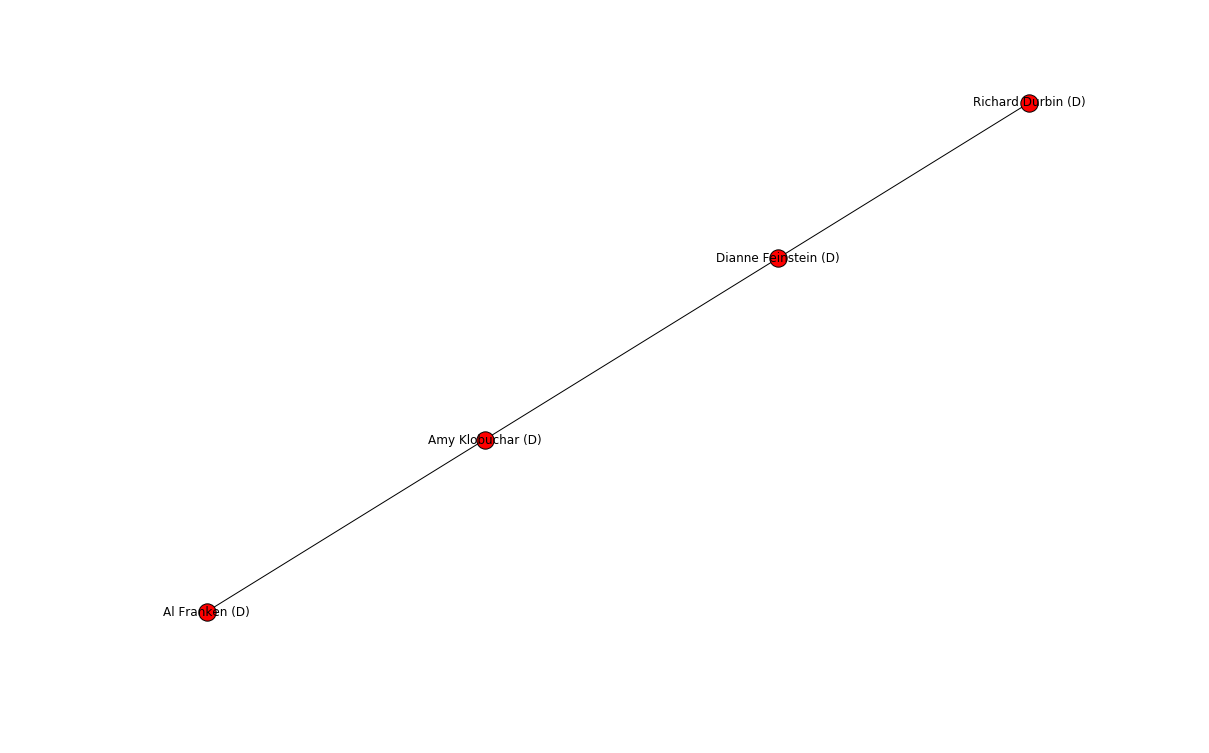

4 Democrats
0 Republicans


In [36]:
senate_island_display(graphs[0])

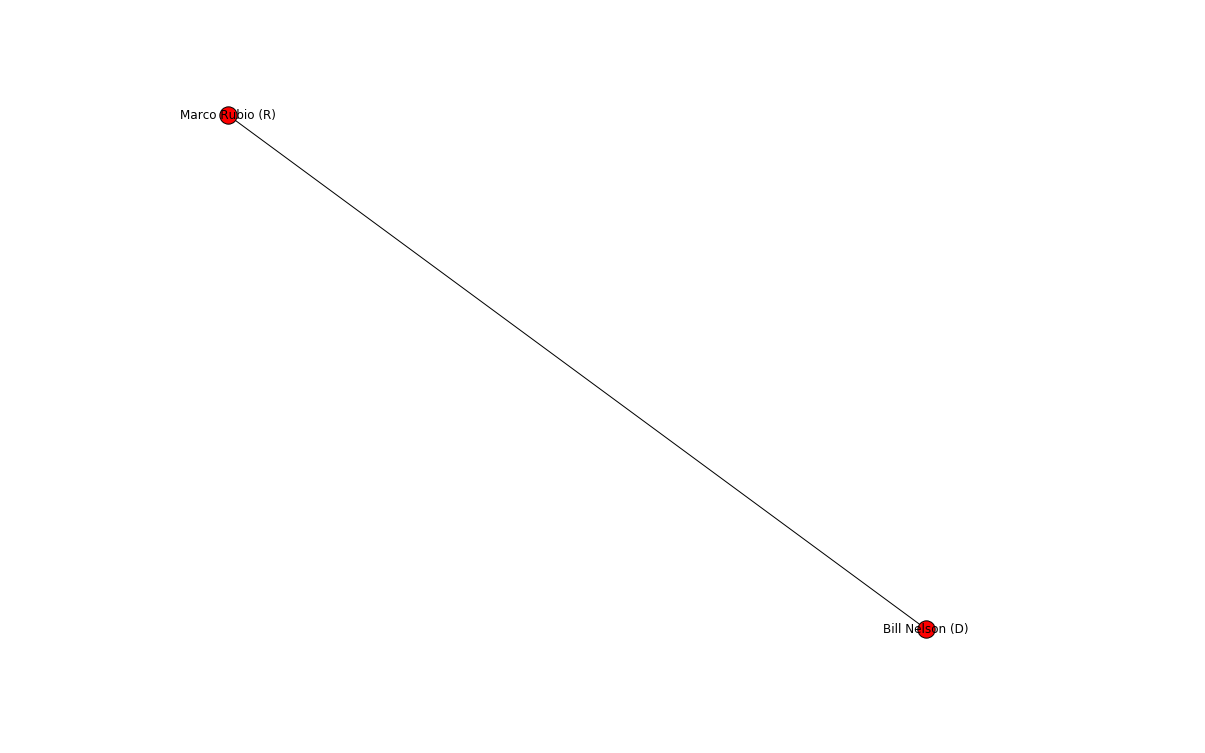

1 Democrats
1 Republicans


In [37]:
senate_island_display(graphs[1])

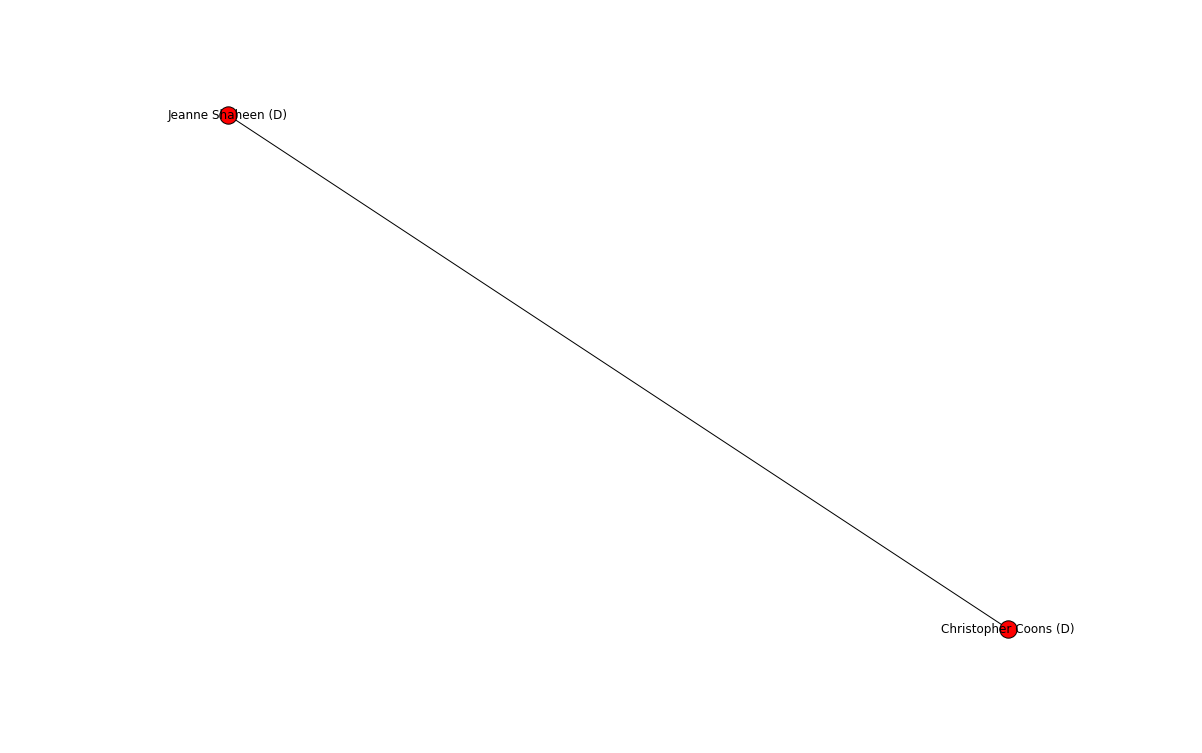

2 Democrats
0 Republicans


In [38]:
senate_island_display(graphs[2])

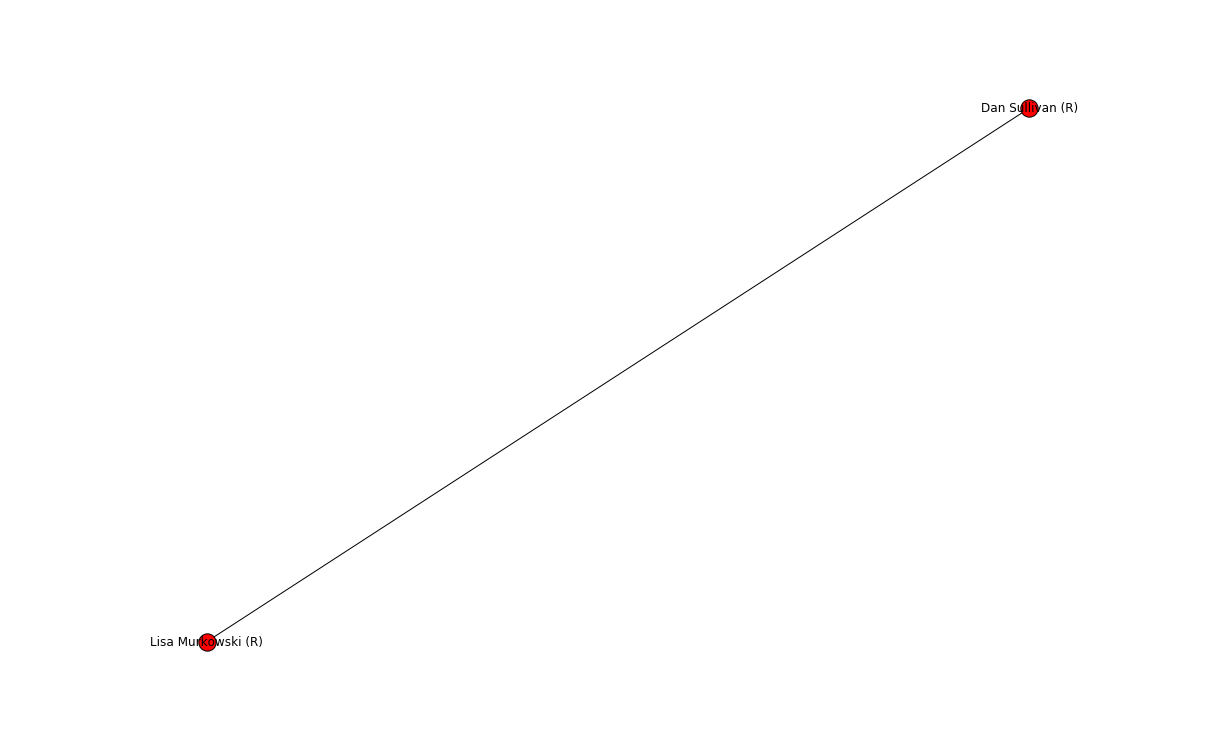

0 Democrats
2 Republicans


In [39]:
senate_island_display(graphs[3])

### Some Insights

It seems that the most connected and influential senators, as detected using the "island method" are majority Democrats -- this, despite the fact that the Senate is majority Republican!  This may point to some fracturing in the Republican side of the aisle, in which Republicans are not working together as well as Democrats are.  It is also interesting that we have three Republicans among the ten highly influential senators we detected -- these Republicans may act as bridges between the majority Republican party and the more connected / united Democratic cluster of influential senators.

## Closer Examination of Bills

Just as we did for Senators, let's check out bills and see if we can identify the most connected bills based on the use of the "island method".

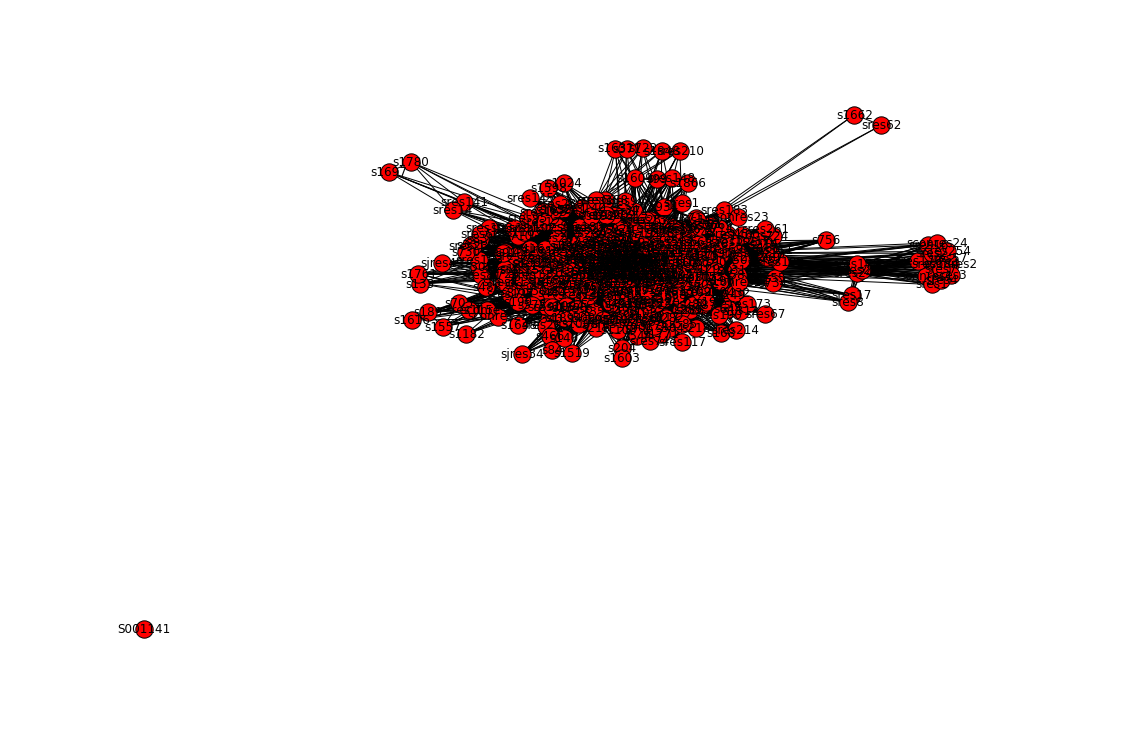

In [40]:
b = bipartite.weighted_projected_graph(g, bills)
plt.figure(2,figsize=(15,10)) 
net.draw_spring(b, with_labels = True)

That's awful. We need to tease this out a bit using the island method.

In [41]:
bill_islands=island_method(b)
bill_islands

[[1, <networkx.classes.graph.Graph at 0x11dd5eb10>],
 [3, <networkx.classes.graph.Graph at 0x11e2c6b10>],
 [5, <networkx.classes.graph.Graph at 0x11f3d0dd0>],
 [7, <networkx.classes.graph.Graph at 0x11f3d0f90>],
 [9, <networkx.classes.graph.Graph at 0x11f3d0f10>],
 [11, <networkx.classes.graph.Graph at 0x11f3d0e90>]]

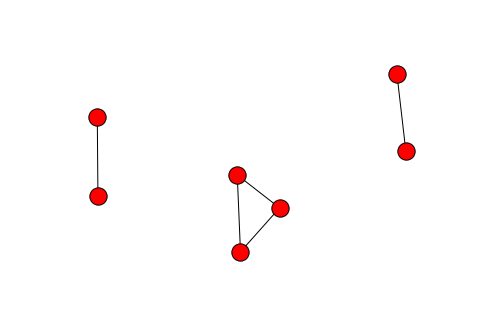

In [42]:
net.draw(bill_islands[5][1])  

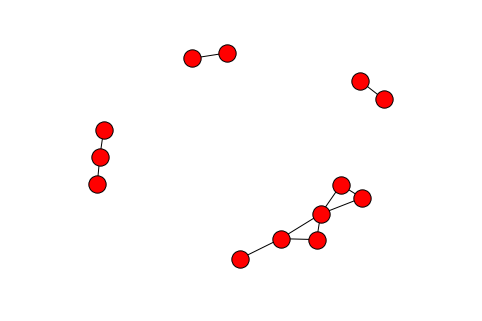

In [43]:
net.draw(bill_islands[4][1])  

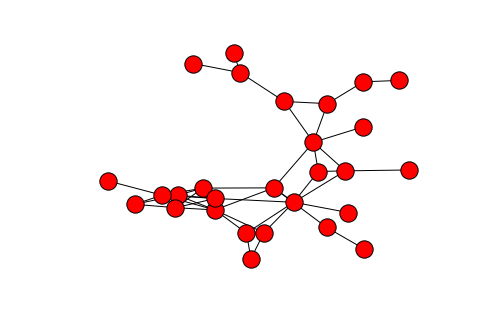

In [44]:
net.draw(bill_islands[3][1])  

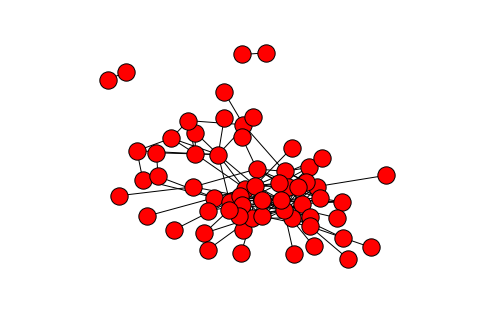

In [45]:
net.draw(bill_islands[2][1])  

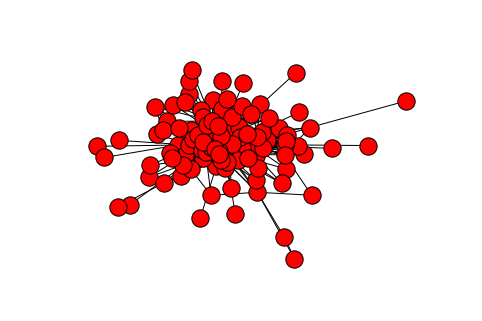

In [46]:
net.draw(bill_islands[1][1])  

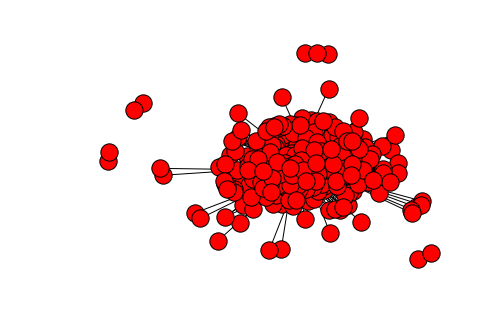

In [47]:
net.draw(bill_islands[0][1])  

In this case, we like the second highest "water mark", which gives us four bill islands.

In [48]:
special_bills = bill_islands[4][1]
graphs = list(net.connected_component_subgraphs(special_bills))
print len(graphs)

4


In [49]:
from textwrap import wrap

def graph_bills(graph):
    bill_info = []
    node_ids = []
    for n in graph:
        bill_long = b.node[n]['title']
        bill_short = '\n'.join(['\n'.join(wrap(block, width=35)) for block in bill_long.splitlines()])
        bill_stuff = bill_short + ' ('  + b.node[n]['sponsor_party'] + ')'  
        node_ids.append(n)
        bill_info.append(bill_stuff)
    bill_dict = dict(zip(node_ids, bill_info))
    pos=net.spring_layout(graph)
    plt.figure(1,figsize=(16,10)) 
    net.draw(graph,pos)
    net.draw_networkx_labels(graph, pos, bill_dict)
    plt.show() # display

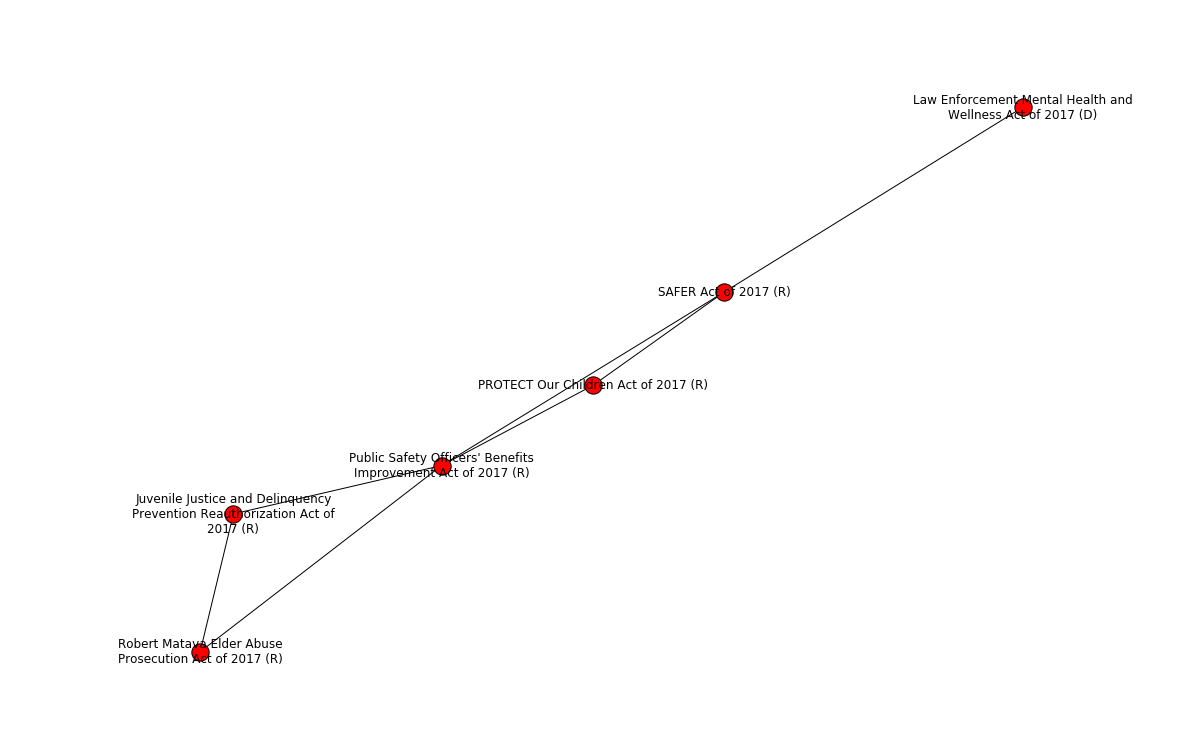

In [50]:
graph_bills(graphs[0])

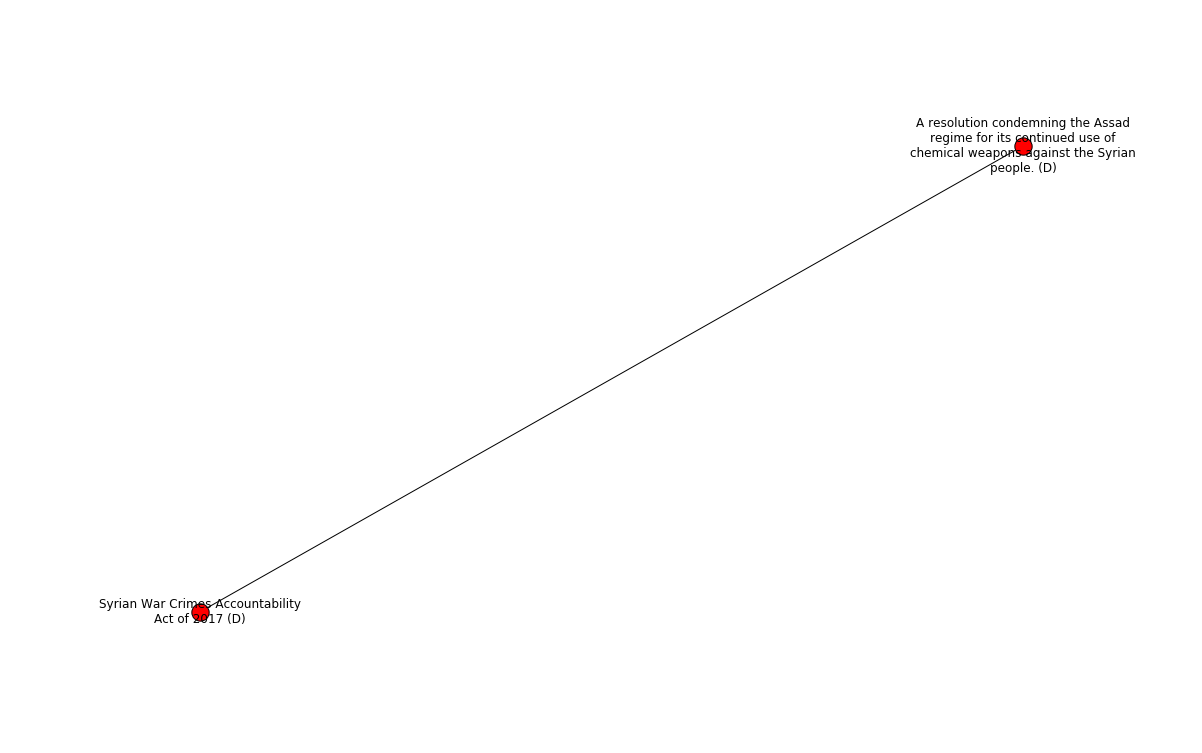

In [51]:
graph_bills(graphs[1])

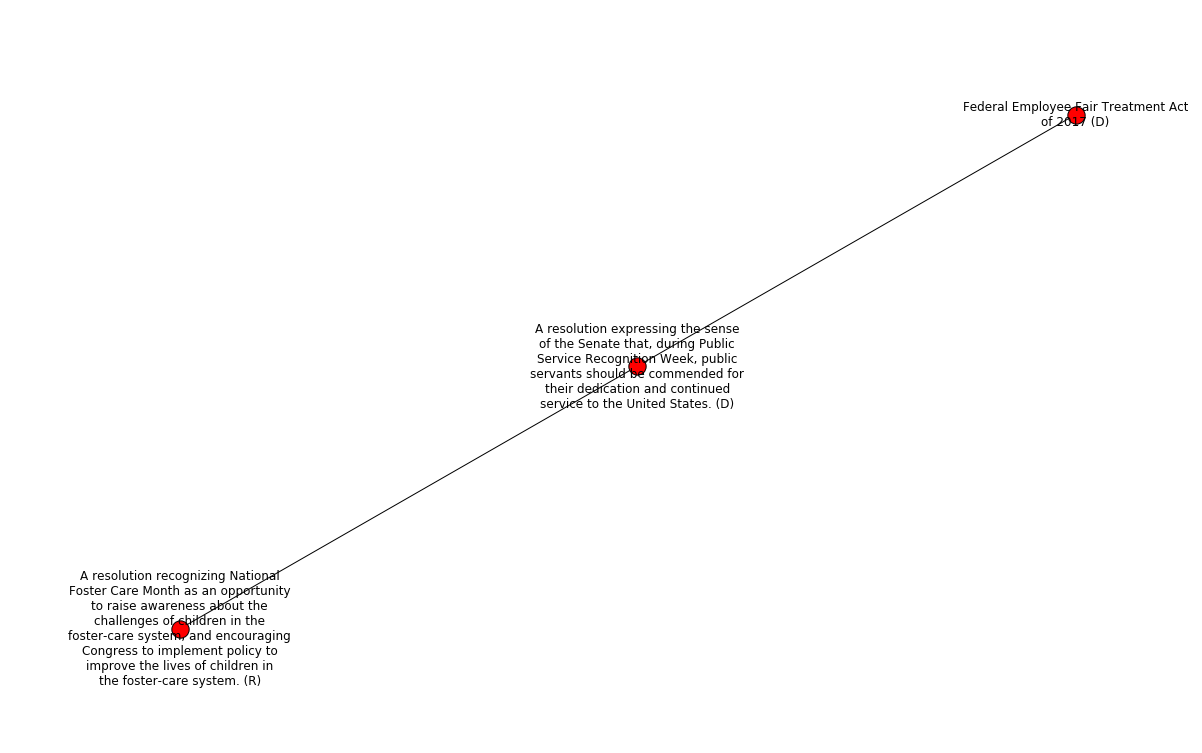

In [52]:
graph_bills(graphs[2])

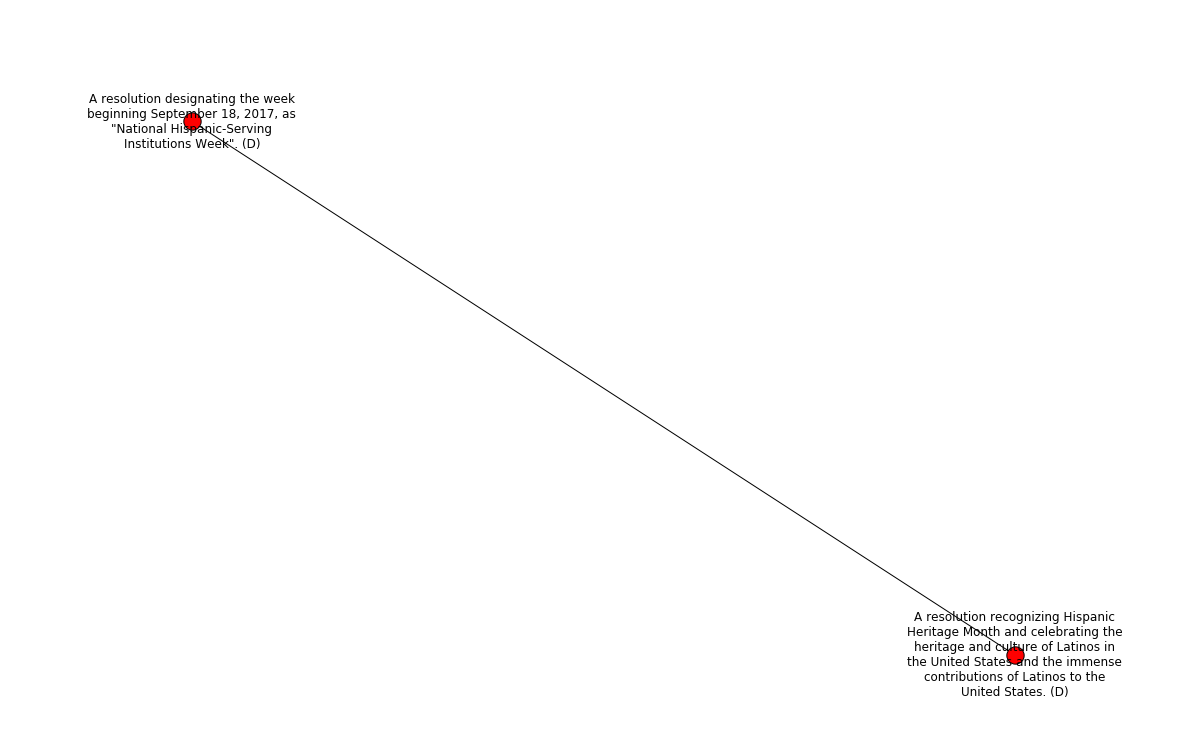

In [53]:
graph_bills(graphs[3])

## Some conclusions

We find that the most "popular" or co-sponsored bills are clustered in several themes:  law enforcement (principally with Republican support), the Syria crisis (supported by Democrats), public sector employees and their work (Democrats), and support of Latino heritage (again, Democrats).  We discover that there are thematic islands of bills with shared Senate support, and that once again, Democratic sponsorship of a bill appears to be more favorable for a bill's connectivity, as compared to Republican sponsorship.  This again brings up the question of whether the US Senate can be characterized as being made up of a minority party that is fairly united, and a majority party that has fragmentation and lack of unity.